# Sentiment Analysis using LSTM
### Group members


*   Ashutosh Chauhan (S20180010017)
*   Pradum Singh (S20180010136)
*   Vipul Rawat (S20180010192)
*   Ayush Gairola (S20180010020)

In [1]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sb
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [4]:
# Download the nltk stopwords to clean the dataset
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Reading the dataset
!unzip "IMDB Dataset.csv.zip"
base_csv = 'IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

Archive:  IMDB Dataset.csv.zip
  inflating: IMDB Dataset.csv        


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


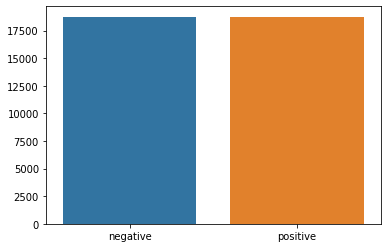

In [8]:
# Visiualizing the dataset 
dd = pd.Series(y_train).value_counts()
sb.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [9]:
def preprocess_string(strg):
    # Remove all non-word characters
    strg = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    strg = re.sub(r"\s+", '', s)
    # replace digits with no space
    strg = re.sub(r"\d", '', s)
    return strg

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    crps = Counter(word_list)
    # sorting on the basis of most common words
    crps_ = sorted(crps,key=crps.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(crps_)}
    
    # tockenize the reviews
    list_train, list_test = [],[]
    for sent in x_train:
            list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    train_encode = [1 if label =='positive' else 0 for label in y_train]  
    test_encode = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(list_train), np.array(train_encode), np.array(list_test), np.array(test_encode), onehot_dict


In [10]:
x_train, y_train, x_test, y_test, vocab = tockenize(x_train,y_train,x_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [44]:
# The length of vocabulary
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


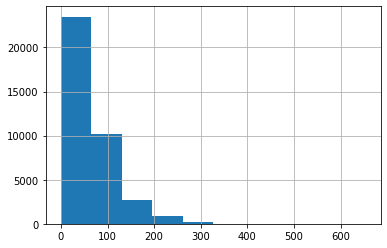

count    37500.000000
mean        69.189653
std         48.243819
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        653.000000
dtype: float64

In [12]:
# Data analysis of the reviews
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [13]:
# Pad the reviews if smaller than max sequence length otherwise trim
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [14]:
# we have very less number of reviews that have length more than 500
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [15]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# Dataloaders
batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [16]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,  44, 162, 769],
        [  0,   0,   0,  ...,   6, 683, 203],
        [  0,   0,   0,  ...,  52,   5, 163],
        ...,
        [  0,   0,   0,  ...,  22, 157, 462],
        [  0,   0,   0,  ..., 311, 209, 116],
        [  0,   0,   0,  ..., 304,  41, 143]])
Sample input: 
 tensor([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 1])


In [18]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [19]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)


SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [20]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import os
os.chdir("MyDrive")

In [36]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'lstm_check.pth')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.41567627161741255 val_loss : 0.3945500817298889
train_accuracy : 82.208 val_accuracy : 82.616
Validation loss decreased (inf --> 0.394550).  Saving model ...
Epoch 2
train_loss : 0.34710920935869216 val_loss : 0.3458595035672188
train_accuracy : 85.31466666666667 val_accuracy : 85.056
Validation loss decreased (0.394550 --> 0.345860).  Saving model ...
Epoch 3
train_loss : 0.3065576640367508 val_loss : 0.34206542098522186
train_accuracy : 87.22933333333333 val_accuracy : 85.648
Validation loss decreased (0.345860 --> 0.342065).  Saving model ...
Epoch 4
train_loss : 0.3000910045305888 val_loss : 0.3407551181912422
train_accuracy : 87.69866666666667 val_accuracy : 85.6
Validation loss decreased (0.342065 --> 0.340755).  Saving model ...
Epoch 5
train_loss : 0.26163314605752624 val_loss : 0.3484104725718498
train_accuracy : 89.35466666666667 val_accuracy : 84.88799999999999


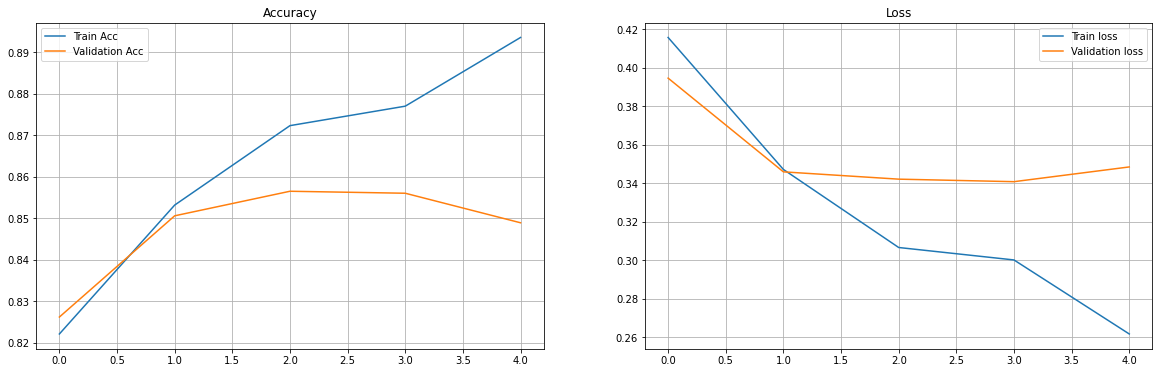

In [37]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [38]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [41]:

index = 45
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

As a disclaimer, I've seen the movie 5-6 times in the last 15 years, and I only just saw the musical this week. This allowed me to judge the movie without being tainted by what was or wasn't in the musical (however, it tainted me when I watched the musical :) ) <br /><br />I actually believe Michael Douglas worked quite well in that role, along with Kasey. I think her 'Let me dance for you scene' is one of the best parts of the movie, a worthwhile addition compared to the musical. The dancers and singing in the movie are much superior to the musical, as well as the cast which is at least 10 times bigger (easier to do in the movie of course). The decors, lighting, dancing, and singing are also much superior in the movie, which should be expected, and was indeed delivered. <br /><br />The songs that were in common with the musical are better done in the movie, the new ones are quite good ones, and the whole movie just delivers more than the musical in my opinion, especially compared to a

In [43]:

index =43
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

I had heard good things about "States of Grace" and came in with an open mind. I thought that "God's Army" was okay, and I thought that maybe Dutcher had improved and matured as a filmmaker. The film began with some shaky acting, and I thought, "well, maybe it will get better." Unfortunately, it never did. The picture starts out by introducing two elders -- Mormon missionaries -- and it seems that the audience will get to know them and grow to care about them. Instead, the story degenerates into a highly improbable series of unfortunate events highlighting blatant disobedience by the missionaries (something that undeniably exists, but rarely on the level that Dutcher portrays) and it becomes almost laughable.<br /><br />Dutcher's only success in this movie is his successful alienation of his target audience. By unrealistically and inaccurately portraying the lives of Mormon missionaries, Dutcher accomplishes nothing more than angering his predominantly Mormon audience. The film in no w